In [1]:
import fiona
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import geopandas as gpd
from shapely.geometry import Point, Polygon

import zipfile
import requests
import os
import shutil

from sklearn.preprocessing import *

from lnks import scl_cols

#import tensorflow as tf

%matplotlib inline

import warnings #DANGER: I triggered a ton of warnings.
warnings.filterwarnings('ignore')

np.random.seed()

# To start...

We import the data output of our data pipeline. We reset the index, drop index columns, and lag the data.

We explicitly print shape several times, making sure that we capture the magnitude of data lost from dropping NA values.

In [2]:
#Shift and shape vars
shiftmonths = 6
shapef = 'anc'
#Assign the split for holdout data.
holdout_date = 2015.5
#Get data
filestring = './data/'+shapef+'_out.csv'
df = pd.read_csv(filestring)
df = df.sort_values(['month', 'NAME'])# , 'ANC'])
df = df.reset_index(drop=True)
len(df.NAME.unique())

40

Now we examine the columns and lag the data.

In [3]:
df.columns

Index(['Unnamed: 0', 'NAME', 'Util_Indx_BBL', 'countBBL', 'countIssued',
       'month', 'TAVG', 'TMAX', 'TMIN', 'Q_GDP', 'BIZ_Dist_Concentr',
       'GS_GRANTS_Concentr', 'LIQUOR_Concentr', 'PHARM_Concentr',
       'GROC_Concentr', 'BANKS_Concentr', 'METRO_Concentr',
       'pct_metro_coverage'],
      dtype='object')

In [4]:
print(df.shape)
shiftnum= (((len(df.NAME.unique()))*(shiftmonths)))

#Also generate some lagged y data in the opposite direction.
df['y']= df['countBBL'].shift(-shiftnum)
df['countBBL_prev_month'] = df['countBBL'].shift((len(df.NAME.unique())))
df['countBBL_prev_cycle'] = df['countBBL'].shift((shiftnum))
df = df[shiftnum:-(shiftnum+(len(df.NAME.unique())))]
df = df.dropna()
df.shape

(2400, 18)


(1880, 21)

The next cell cleans out vestigial columns and drops/fills/expands to dummies for our NA and categorical values.

In [5]:
df = pd.get_dummies(df, columns=['NAME'])
df = df.drop(['Unnamed: 0'], axis= 1)
print(df.shape)
df = df.astype('float')

df = df.dropna()
print(df.shape)

(1880, 59)
(1880, 59)


Here we start building our grid search inputs, beginning with the splits.

In [6]:
#Flexible adaptation of Dr. Braman's interactive gridsearch script
#implementation. 
#TODO Clean up and streamline
import sklearn
from sklearn.neural_network import *
from sklearn.neighbors import *
from sklearn.svm import *
from sklearn.gaussian_process import *
from sklearn.gaussian_process.kernels import *
from sklearn.tree import *
from sklearn.ensemble import *
from sklearn.naive_bayes import *
from sklearn.discriminant_analysis import *
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.preprocessing import *
import random

#Frame up some separate DataFrames for scalar and stuff
scl_data = data = df



data     = data.reset_index(drop=True)
X = data.drop(['y'], axis=1)
y = data['y']

XH_train = data[data['month'] <= holdout_date-1]
yH_train = XH_train['y']
XH_train = XH_train.drop(['y'], axis=1)

XH_val = scl_data[scl_data['month'] >= holdout_date-1]
XH_val = XH_val[XH_val['month'] <= holdout_date]

yH_val = XH_val['y']
XH_val = XH_val.drop(['y'], axis=1)

XH_test  = data[data['month'] >= holdout_date]
yH_test  = XH_test['y']
XH_test  = XH_test.drop(['y'], axis=1)

ytr = sklearn.preprocessing.MinMaxScaler([0, 1]
            ).fit(y)
y = ytr.fit_transform(y)
y = pd.DataFrame(y, columns=['y'])

scl_data = scl_data.reset_index(drop=True)

In [7]:
y.y

0       0.080640
1       0.111329
2       0.095658
3       0.023833
4       0.102514
5       0.290565
6       0.146915
7       0.003591
8       0.104146
9       0.105126
10      0.035586
11      0.059092
12      0.047013
13      0.037871
14      0.027424
15      0.017630
16      0.031342
17      0.071172
18      0.068560
19      0.039177
20      0.021548
21      0.036565
22      0.091414
23      0.077375
24      0.094352
25      0.085211
26      0.112635
27      0.099576
28      0.075743
29      0.051257
          ...   
1850    0.174665
1851    0.244205
1852    0.235390
1853    0.142018
1854    0.133203
1855    0.083578
1856    0.139732
1857    0.249102
1858    0.233758
1859    0.158015
1860    0.135162
1861    0.164871
1862    0.339536
1863    0.290238
1864    0.389161
1865    0.336272
1866    0.457721
1867    0.388182
1868    0.334966
1869    0.307542
1870    0.183480
1871    0.140059
1872    0.159321
1873    0.153771
1874    0.113614
1875    0.202742
1876    0.093373
1877    0.1661

In [8]:
print(scl_data.month.max())
print(scl_data.shape)
scl_data = scl_data.dropna()
print(scl_data.shape)
sXH_train = scl_data[scl_data['month'] <= holdout_date-1]
syH_train = sXH_train['y']
sXH_train = sXH_train.drop(['y'], axis=1)

sXH_val = scl_data[scl_data['month'] >= holdout_date-1]
sXH_val = sXH_val[sXH_val['month'] <= holdout_date]

syH_val = sXH_val['y']
sXH_val = sXH_val.drop(['y'], axis=1)


sXH_test  = scl_data[scl_data['month'] >= holdout_date]
syH_test  = sXH_test['y']
sXH_test  = sXH_test.drop(['y'], axis=1)

2016.05
(1880, 59)
(1880, 59)


In [9]:
#Build scalers for the scl_data, other --------------------
scale_data_splits = [scl_data, sXH_train,sXH_test, syH_train, syH_test]
for scl_data in scale_data_splits:
    scaler = sklearn.preprocessing.StandardScaler(
                ).fit(scl_data)
    minmaxer = sklearn.preprocessing.MinMaxScaler([0, 1]
                ).fit(scl_data)

    scl = scaler.transform(scl_data)
    scl = minmaxer.transform(scl_data)
    try:
        scl_data = pd.DataFrame(scl, columns=scl_data.columns)
    except AttributeError as e:
        print(e)
        scl_data = pd.DataFrame(scl, columns=['y'])
    print(scl_data.shape)
    scl_data = scl_data.dropna()
    print(scl_data.shape)
    assert np.all(np.isfinite(scl_data))
    assert not np.any(np.isnan(scl_data))
    
    
#scl_data[scl_data.columns
#   ] = scaler.fit_transform(scl_data[scl_data.columns])

#----------------------------------------------------------


(1880, 59)
(1880, 59)
(1200, 58)
(1200, 58)
(200, 58)
(200, 58)
'Series' object has no attribute 'columns'
(1200, 1)
(1200, 1)
'Series' object has no attribute 'columns'
(200, 1)
(200, 1)


Let's make sure our data came out of the scalers intact:

In [10]:
y;

In [11]:
print(sXH_train.shape)
print(syH_train.shape)
print(sXH_test.shape)
print(syH_test.shape)


(1200, 58)
(1200,)
(200, 58)
(200,)


In [12]:
scl_data.columns

Index(['y'], dtype='object')

In [13]:
sX = scl_data.drop(['y'], axis=1)
sy = scl_data['y']



assert np.all(np.isfinite(X))
assert np.all(np.isfinite(y))
assert not np.any(np.isnan(X))
assert not np.any(np.isnan(y))

assert np.all(np.isfinite(sX))
assert np.all(np.isfinite(sy))
assert not np.any(np.isnan(sX))
assert not np.any(np.isnan(sy))

In [14]:
scl_data.columns

Index(['y'], dtype='object')

In [15]:
scl_data.describe()

,y
count,200.000000
mean,0.219565
std,0.157940
min,0.000000
25%,0.113454
50%,0.180388
75%,0.309153
max,1.000000


This cell contains our a crude RNG, a list of regressors which benefit from scaled data, and hardcoded data used to generate our param_grid, et cetera.

In [16]:
#Make a short list of random states to insert into randomstate params.
scrambler = []
for scram in range(0, 10):
    scrambler.append(random.randint(0, 10000))   
print(scrambler)

to_scale = ['SVR']

names       = ['AdaBoostRegressor',
             'RandomForestRegressor',
             'SVR',
             #'KNeighborsRegressor',
             #'BaggingRegressor',
             'GradientBoostingRegressor',
             #'LinearRegression',
             #'MLPRegressor',
             #'SGDRegressor',
             'LassoLars'         
    
]

regressors = [AdaBoostRegressor(),
              RandomForestRegressor(),
              SVR(),
              #KNeighborsRegressor(),
              #BaggingRegressor(),
              GradientBoostingRegressor(),
              #LinearRegression(),
              #MLPRegressor(),
              #SGDRegressor(),
              LassoLars()
    
]

param_grids =[ 
    ['AdaBoostRegressor', dict(
        n_estimators=[80, 60, 30],
        learning_rate=[1, .5, .01],
        loss=['linear', 'square', 'exponential'],
        #random_state=scrambler[3:5]
        
    )],
        
    ['RandomForestRegressor', dict(
        max_depth=[5, 10, 15],
        criterion=['mse', 'mae'],
        #random_state=scrambler[:2]
    )],
    ['SVR', dict( #Most params for SVR are turned off right now, too expensive
        C=[1, .9],
        epsilon=[.1, .05],
        #kernel=['poly']
    )],
    ['GradientBoostingRegressor', dict(
        max_depth=[3, 6, 9, 12],
        min_samples_split=[2, 4, 8],
        presort=[False]
    )],
    ['LassoLars', dict(
        alpha=[0.1, 1, .5, .75],
        #random_state=[random.randint(0, 10000)]
    )],
    ]

[3094, 9887, 7708, 7484, 3931, 4211, 5116, 4521, 3052, 459]


## Grid Search:

Here we implement an iterator that executes GridSearchCV and reports the best explained variance. The best_params attribute is then extracted, and used those on the whole training set, then predict on the holdout data.

Testing indicates that for some models, the fit on our full dataset modestly outperforms the CV regularly.

In [17]:
outcomes = []

for name, rgsr in zip(names, regressors):
    
    for item in param_grids:
        if item[0]==name:
            print(name + ':')
            params= item[1]
        
    
    cv = sklearn.model_selection.GridSearchCV(rgsr, param_grid=params,
                                              verbose=True, n_jobs=12,
                                              cv=3, pre_dispatch="2*n_jobs")
    
    if name not in to_scale:
        #X_train, y_train, X_test, y_test = sklearn.model_selection.train_test_split(X, y)
        fitted = cv.fit(XH_train, yH_train)
        score = cv.score(XH_val, yH_val)
        print(score)

        best = rgsr.set_params(**cv.best_params_)
        bestfit= best.fit(XH_train, yH_train)
        bestscore = best.score(XH_test, yH_test)
    if name in to_scale:
    #TODO: fix
        #X_train, y_train, X_test, y_test = sklearn.model_selection.train_test_split(sX, sy)
        fitted = cv.fit(sXH_train, syH_train)
        score = cv.score(sXH_val, syH_val)
        print(score)

        best = rgsr.set_params(**cv.best_params_)
        bestfit= best.fit(sXH_train, syH_train)
        bestscore = best.score(sXH_test, syH_test)

    print(name + " R2 with best model, score:")
    print(bestscore)
    
    
    outcomes.append((name, score, cv.cv_results_, cv.best_estimator_, 
                     cv.best_params_, bestscore, [yH_test, ]))
    
for nm in range(0, len(outcomes)):
    print()
    print(outcomes[nm][0])
    print(outcomes[nm][1])
    print()
    print('Best on real:')
    print(outcomes[nm][-1])

AdaBoostRegressor:
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    4.9s
[Parallel(n_jobs=12)]: Done  81 out of  81 | elapsed:   12.7s finished


0.663722867574
AdaBoostRegressor R2 with best model, score:
0.180380746937
RandomForestRegressor:
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=12)]: Done  14 out of  18 | elapsed:    4.0s remaining:    1.1s
[Parallel(n_jobs=12)]: Done  18 out of  18 | elapsed:    4.4s finished


0.653730250057
RandomForestRegressor R2 with best model, score:
0.211558818979
SVR:
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.8s remaining:    4.0s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    1.3s finished


-0.464336350247
SVR R2 with best model, score:
-1.22957283607
GradientBoostingRegressor:
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=12)]: Done  36 out of  36 | elapsed:   13.1s finished


0.638103988224
GradientBoostingRegressor R2 with best model, score:
0.270062226851
LassoLars:
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.4s remaining:    1.8s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.7s finished


0.708104560166
LassoLars R2 with best model, score:
0.672667701012

AdaBoostRegressor
0.663722867574

Best on real:
0.180380746937

RandomForestRegressor
0.653730250057

Best on real:
0.211558818979

SVR
-0.464336350247

Best on real:
-1.22957283607

GradientBoostingRegressor
0.638103988224

Best on real:
0.270062226851

LassoLars
0.708104560166

Best on real:
0.672667701012


In [18]:
#Adapted from https://pythonspot.com/en/matplotlib-bar-chart/

objects     = [j[0] for j in outcomes]
y_pos       = np.arange(len(objects))

performance = [j[-1] for j in outcomes]
for jm in range(len(performance)):
    if performance[jm] < 0:
        performance[jm] = 0
performance

[0.18038074693735406,
 0.21155881897892145,
 0,
 0.2700622268508992,
 0.67266770101154427]

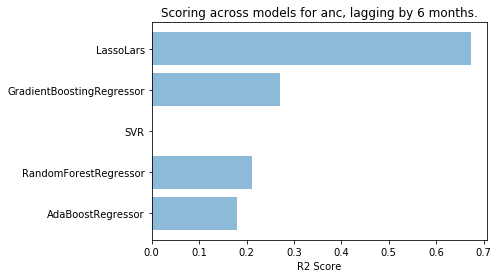

In [19]:
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('R2 Score')
ti = "Scoring across models for "+shapef+", lagging by "+str(shiftmonths)+ " months."
plt.title(ti)
fl = './plots/' + shapef + "_shift" + str(shiftmonths)
plt.savefig(fl)

# Everything below is exploratory analysis for me.

In [20]:
for jm in range(0, 5):
    
    print(outcomes[jm][0])
    
    print(outcomes[jm][1])
    print(outcomes[jm][4])

AdaBoostRegressor
0.663722867574
{'learning_rate': 1, 'loss': 'square', 'n_estimators': 80}
RandomForestRegressor
0.653730250057
{'criterion': 'mse', 'max_depth': 10}
SVR
-0.464336350247
{'C': 1, 'epsilon': 0.1}
GradientBoostingRegressor
0.638103988224
{'max_depth': 3, 'min_samples_split': 8, 'presort': False}
LassoLars
0.708104560166
{'alpha': 0.1}


In [21]:
best = AdaBoostRegressor(learning_rate=1, loss='square', n_estimators=60)
bestfit= best.fit(XH_train, yH_train)
bestscore = best.score(XH_test, yH_test)
print(outcomes[0][0])
print(bestscore)

best = RandomForestRegressor(max_depth=10)
bestfit= best.fit(XH_train, yH_train)
bestscore = best.score(XH_test, yH_test)
print(outcomes[1][0])
print(bestscore)

best = SVR(max_depth=10)
bestfit= best.fit(XH_train, yH_train)
bestscore = best.score(XH_test, yH_test)
print(outcomes[2][0])
print(bestscore)


best = GradientBoostingRegressor(max_depth=10)
bestfit= best.fit(XH_train, yH_train)
bestscore = best.score(XH_test, yH_test)
print(outcomes[3][0])
print(bestscore)

AdaBoostRegressor
0.189445424722
RandomForestRegressor
0.274402422932


TypeError: __init__() got an unexpected keyword argument 'max_depth'

In [ ]:


Xtrain = dat_xtrain.drop(['y'], axis=1)
y16 = dat_ytrain['y']
X15 = dat15.drop(['y'], axis=1)
y15 = dat15['y']

fitted    = outcomes[-2][3].fit(X15, y15)
predicted = fitted.predict(X16)

In [ ]:
pred = pd.DataFrame(predicted, columns=['predicted'])
dat16 = dat16.reset_index()
pred['y'] = dat16['y']

In [ ]:
def flagger_ranges(pred):
    pred['flag15'] = 0
    pred['flag15'][pred['predicted'].between(pred['y']*0.85, pred['y']*1.15)
                  ] = 1
    pred['flag05'] = 0
    pred['flag05'][pred['predicted'].between(pred['y']*0.85, pred['y']*1.15)
                  ] = 1
    pred['flag10'] = 0
    pred['flag10'][pred['predicted'].between(pred['y']*0.85, pred['y']*1.15)
                  ] = 1
    pred['flag_others']= 0
    pred['flag_others'][pred['flag05'] == 0] = 1
    return pred
pred = flagger_ranges(pred)
pred